In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df_missing = pd.read_csv('../Data/df_transformed.csv')
df_missing.drop('Unnamed: 0',axis=1,inplace=True)
df_imputed = pd.read_csv('../Data/dfi_transformed.csv')
df_imputed.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
Models = {
}

In [4]:
def model(number,return_model=False, return_xy=False):
    global Models,df_missing,df_imputed
    info = {}
    info['number']=number
    imputed = False
    num_variables=['RIDAGEYR','BPXPLS','Systolic','Diastolic']
    cat_variables =['RIAGENDR','RIDRETH3']
    info['imputed']=1    
    if number % 2 == 0: # use imputed values (remember to drop na before train test split)
        df = df_missing
        info['imputed']=0
    else:
        df = df_imputed
        imputed = True
        cat_variables.extend(['BPXPLS_i','Systolic_i','Diastolic_i'])
    number = (number - number%2)//2
    info['drop outliers']=0
    if number%2==1: # drop outliers
        info['drop outliers']=1
        df = df[df.outlier==0].copy()
    number = (number - number%2)//2
    info['limit y range']=0
    if number % 2 == 1: # reduce y range
        info['limit y range']=1
        number -= 1
        df = df[(df.LBXTC>=100)&(df.LBXTC<400)].copy()
    number = number//2
    info['bmi only']=1
    if number % 2 == 1: # use height and weight
        info['bmi only']=0
        number = number - 1
        num_variables.extend([ 'BMXWT', 'BMXHT'])
        if imputed:
            cat_variables.extend(['BMXWT_i', 'BMXHT_i'])
    else:
        num_variables.append('BMXBMI')
        if imputed:
            cat_variables.append('BMXBMI_i')
    number = number//2
    info['include pulse irregularity']=0
    if number%2==1: # include irregular pulse
        info['include pulse irregularity']=1
        number -= 1
        cat_variables.append('BPXPULS')
        if imputed:
            cat_variables.append('BPXPULS_i')
    number = number//2
    info['include chronic conditions']=0
    if number % 2 == 1: # include chronic conditions
        number -= 1
        info['include chronic conditions']=1
        cat_variables.extend(['BPQ020', 'BPQ050A', 'BPQ080','BPQ100D', 'DIQ010', 'MCQ170M'])
        if imputed:
            cat_variables.extend(['BPQ020_i', 'BPQ050A_i', 'BPQ080_i', 'BPQ100D_i', 'DIQ010_i','MCQ170M_i'])
    number = number//2
    info['use transformed physical activity']=0
    if number % 2 == 1: # use transformed physical activity
        number -= 1
        info['use transformed physical activity']=1
        num_variables.append('MET_rec')
        if imputed:
            cat_variables.append('MET_rec_i')
    else:
        num_variables.extend(['PAQ655','PAD660','PAQ670','PAD675'])
        if imputed:
            cat_variables.extend(['PAQ655_i','PAD660_i','PAQ670_i','PAD675_i'])
    number = number // 2
    info['include nutrients']=0
    info['nutrient variable type']=np.nan    
    if number%2 == 0: # don't include nutrients
        number = (number - number%6)//6
    else:
        info['include nutrients']=1
        number = (number-1)//2
        if number % 3 == 0: # include original nutrients
            num_variables.extend(['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA'])
            cat_variables.append('DR1_300')
            if imputed:
                cat_variables.append('DR1_300_i')
            info['nutrient variable type']='original'
        elif number % 3 == 1: # include transformed nutrients
            info['nutrient variable type']='transformed'
            num_variables.extend(['DR1TKCAL_t',
       'DR1TPROT_t', 'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t',
       'DR1TSFAT_t', 'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t',
       'DR1TVD_t', 'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t'])
            if imputed:
                cat_variables.append('DR1_300_i')
        else: # include both
            info['nutrient variable type']='both'
            num_variables.extend(['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA','DR1TKCAL_t',
       'DR1TPROT_t', 'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t',
       'DR1TSFAT_t', 'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t',
       'DR1TVD_t', 'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t'])
            if imputed:
                cat_variables.append('DR1_300_i')
        number = (number - number%3)//3
    info['include alcohol and tobacco']=0
    info['alcohol variable type']=np.nan    
    if number % 2 == 0: # don't include alcohol and tobacco
        number = (number - number % 6)//6
    else: # include alcohol and tobacco
        number = (number - 1)//2
        # add tobacco here
        cat_variables.append('SMQ681')
        info['include alcohol and tobacco']=1
        if imputed:
            cat_variables.append('SMQ681_i')
        if number % 3 == 0: # include original alcohol quantities
            info['alcohol variable type']='original'
            num_variables.extend([ 'ALQ120Q','ALQ130'])
            cat_variables.append('ALQ120U')
            if imputed:
                cat_variables.extend(['ALQ120Q_i', 'ALQ120U_i', 'ALQ130_i'])
        elif number % 3 == 1: # include transformed alcohol quantities
            info['alcohol variable type']='transformed'
            num_variables.append('avgALC')
            if imputed:
                cat_variables.append('avgALC_i')
        else: # include both
            info['alcohol variable type']='both'
            num_variables.extend([ 'ALQ120Q','ALQ130','avgALC'])
            cat_variables.append('ALQ120U')
            if imputed:
                cat_variables.extend(['ALQ120Q_i', 'ALQ120U_i', 'ALQ130_i','avgALC_i'])
        number = (number-number%3)//3
    df = df[num_variables+cat_variables+['LBXTC','log_LBXTC']].copy()
    df.dropna(inplace=True)
    y = df.LBXTC
    info['log transform y']=0
    if number % 2 == 1: # use log transformed y
        info['log transform y']=1
        number -= 1
        y = df.log_LBXTC
    number = number//2
    X = df[num_variables+cat_variables].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)
    numeric_transformer = Pipeline(steps=[('scalar',MinMaxScaler())])
    cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])
    info['Winsorize x']=0
    if number % 2 == 1: # Winsorize x
        info['Winsorize x']=1
        numeric_transformer.steps.insert(0,('winsorizor',Winsorizer()))
        number -= 1
    number = number//2
    info['log transform numeric variables']=0
    if number % 2 == 1: # log transform x
        info['log transform numeric variables']=1
        number -= 1
        numeric_transformer.steps.insert(0,('log transform x',FunctionTransformer(np.log1p)))
    number = number // 2
    preprocessor = ColumnTransformer(transformers=[
        ('num',numeric_transformer,num_variables),
        ('cat',cat_transformer,cat_variables)])
    svr1 = Pipeline(steps =[
        ('preprocessor',preprocessor),
        ('svr', SVR())])
    info['include PCA']=0
    if number % 2 == 1: # add PCA
        svr1.steps.insert(1,("pca",PCA(0.95)))
        info['include PCA']=1

    svr1.fit(X_train,y_train)
    
    r2 = svr1.score(X_train,y_train)
    info['r2']=r2
    k = svr1.named_steps['svr'].shape_fit_[1]
    n = svr1.named_steps['svr'].shape_fit_[0]
    ar2 = ((1-r2)/(n-1))/(n-k-1)
    info['adjusted r2']=ar2
    y_train_preds = svr1.predict(X_train)
    y_preds = svr1.predict(X_test)
    
    info['training MAE'] = mean_absolute_error(y_train,y_train_preds)
    info['testing MAE'] = mean_absolute_error(y_test,y_preds)
    info['training RMSE'] = mean_squared_error(y_train,y_train_preds,squared=False)
    info['testing RMSE'] = mean_squared_error(y_test,y_preds,squared=False)
    info['MAE percent difference'] = (info['testing MAE']-info['training MAE'])/info['training MAE']
    info['RMSE percent difference'] = (info['testing RMSE']-info['training RMSE'])/info['training RMSE']
    if return_model:
        if return_xy:
            return (svr1, X_train, X_test, y_train, y_train_preds,y_test,y_preds)
        return (svr1, info)
    for key in info.keys():
        if key not in Models:
            Models[key]=[]
        Models[key].append(info[key])

In [5]:
model_numbers = []
for i in range(100):
    n = np.random.randint(73728)
    while n in model_numbers:
        n = np.random.randint(73728)
    model_numbers.append(n)
    model(n)
models = pd.DataFrame(Models)
top_10 = models.sort_values(by='adjusted r2',ascending=False).head(10)
top_10

,number,imputed,drop outliers,limit y range,bmi only,include pulse irregularity,include chronic conditions,use transformed physical activity,include nutrients,nutrient variable type,...,log transform numeric variables,include PCA,r2,adjusted r2,training MAE,testing MAE,training RMSE,testing RMSE,MAE percent difference,RMSE percent difference
75,67466,0,1,0,0,0,0,0,1,both,...,1,1,0.045288,1.167605e-07,31.238591,30.630525,41.402353,39.485932,-0.019465,-0.046288
41,41044,0,0,1,1,1,0,1,0,NaN,...,0,1,0.043876,1.164027e-07,30.464441,31.204436,39.041678,39.174896,0.024290,0.003412
51,21342,0,1,1,0,1,0,1,0,NaN,...,1,0,0.054182,1.163639e-07,30.418397,30.438515,38.813639,39.273239,0.000661,0.011841
39,28484,0,0,1,1,0,0,1,0,NaN,...,1,0,0.057921,1.151356e-07,30.200052,31.131632,38.753880,39.063825,0.030847,0.007998
82,2738,0,1,0,1,1,1,0,1,transformed,...,0,0,0.120618,1.117754e-07,29.655898,29.336974,39.503953,38.145973,-0.010754,-0.034376
22,50430,0,1,1,0,1,1,1,1,transformed,...,0,1,0.131063,1.107961e-07,28.752365,29.853168,36.955115,38.171083,0.038286,0.032904
0,40808,0,0,0,0,0,1,1,0,NaN,...,0,1,0.114358,1.095740e-07,29.496214,31.030976,38.978645,40.936109,0.052033,0.050219
58,22328,0,0,0,0,1,1,0,0,NaN,...,1,0,0.126750,1.090792e-07,29.211526,30.758884,38.704981,40.732923,0.052971,0.052395
65,2366,0,1,1,0,1,1,0,0,NaN,...,0,0,0.141985,1.090554e-07,28.528975,29.894490,36.713823,38.388424,0.047864,0.045612
16,67308,0,0,1,0,0,1,1,1,transformed,...,1,1,0.137458,1.089658e-07,28.551985,29.296006,36.921646,36.956104,0.026058,0.000933


In [6]:
top_10.transpose(copy=True)

,75,41,51,39,82,22,0,58,65,16
number,67466,41044,21342,28484,2738,50430,40808,22328,2366,67308
imputed,0,0,0,0,0,0,0,0,0,0
drop outliers,1,0,1,0,1,1,0,0,1,0
limit y range,0,1,1,1,0,1,0,0,1,1
bmi only,0,1,0,1,1,0,0,0,0,0
include pulse irregularity,0,1,1,0,1,1,0,1,1,0
include chronic conditions,0,0,0,0,1,1,1,1,1,1
use transformed physical activity,0,1,1,1,0,1,1,0,0,1
include nutrients,1,0,0,0,1,1,0,0,0,1
nutrient variable type,both,NaN,NaN,NaN,transformed,transformed,NaN,NaN,NaN,transformed


In [7]:
sv1, X_train, X_test, y_train, y_train_preds,y_test,y_preds = model(85414, return_model=True, return_xy=True)

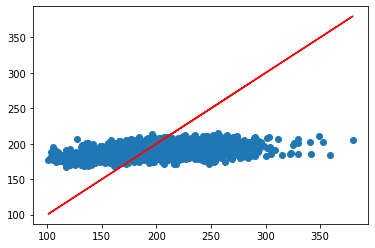

In [8]:
plt.scatter(y_train, y_train_preds)
plt.plot(y_train, y_train, color="red")